In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pandas as pd
import pickle as pkl
import random
import pdb
from tqdm import tqdm_notebook


In [3]:
random.seed(186)

BATCH_SIZE = 256
MAX_SENTENCE_LENGTH = 1000
EMBED_SIZE = 300
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
PAD = '<pad>'
UNK = '<unk>'

label_to_id = {'contradiction' : 0, 'entailment' : 1, 'neutral' : 2}

def load_fasttext():
    fasttext_home = './'
    words_to_load = 50000

    loaded_embeddings = np.zeros((words_to_load + 2, EMBED_SIZE)) #+2 to account for pad and unk tokens
    words = {}
    idx2words = {}
    with open(fasttext_home + 'wiki-news-300d-1M.vec') as f:
        loaded_embeddings[PAD_IDX, :] = np.zeros((1, EMBED_SIZE))
        loaded_embeddings[UNK_IDX, :] = np.zeros((1, EMBED_SIZE))
        words[PAD] = PAD_IDX
        words[UNK] = UNK_IDX
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split()
            idx = i + 2 #+2 to account for PAD and UNK tokens
            loaded_embeddings[idx, :] = np.asarray(s[1:])
            words[s[0]] = idx 
            idx2words[idx] = s[0]
    return loaded_embeddings, words, idx2words

def load_snli_data():
    snli_train = pd.read_csv('./snli_train.tsv', names=['sentence1', 'sentence2', 'label'], skiprows=1, sep='\t|\n', engine='python')
    snli_val = pd.read_csv('./snli_val.tsv', names=['sentence1', 'sentence2', 'label'], skiprows=1, sep='\t|\n', engine='python')
    return snli_train[['sentence1', 'sentence2']], [label_to_id[x] for x in snli_train['label']], snli_val[['sentence1', 'sentence2']], [label_to_id[x] for x in snli_val['label']]


In [4]:
loaded_embeddings, words, idx2words = load_fasttext()

In [5]:
snli_train_sentences, snli_train_labels, snli_val_sentences, snli_val_labels = load_snli_data()
def map_sentence_to_idxs(sentence):
    return [words[tkn] if tkn in words else UNK_IDX for tkn in sentence]
snli_train_sentences_idxs = snli_train_sentences.applymap(lambda x: map_sentence_to_idxs(x))
snli_val_sentences_idxs = snli_val_sentences.applymap(lambda x: map_sentence_to_idxs(x))

In [6]:
class SNLIDataset(Dataset):    
    def __init__(self, data_list, target_list):
        """
        @param data_list: two sentence lists 
        @param target_list: list of targets 

        """
        self.x1 = data_list['sentence1']
        self.x2 = data_list['sentence2']
        self.y = target_list
        assert (len(self.x1) == len(self.x2) == len(self.y))

    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, key):        
        sent1_idx = self.x1[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.x2[key][:MAX_SENTENCE_LENGTH]
        label = self.y[key]
        return [sent1_idx, sent2_idx, len(sent1_idx), len(sent2_idx), label]

def SNLI_collate_function(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sentence1_list = []
    sentence2_list = []
    label_list = []
    length_list_1 = []
    length_list_2 = []
    # padding
    for datum in batch:
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
        label_list.append(datum[4])
        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        sentence1_list.append(padded_vec_1)
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        sentence2_list.append(padded_vec_2)
    return [torch.from_numpy(np.array(sentence1_list)), torch.from_numpy(np.array(sentence2_list)), 
#             torch.cuda.LongTensor(length_list_1), torch.cuda.LongTensor(length_list_2), 
            torch.cuda.LongTensor(label_list)]
#             torch.LongTensor(label_list)]

In [7]:
snli_train_dataset = SNLIDataset(snli_train_sentences_idxs, snli_train_labels)
snli_train_loader = torch.utils.data.DataLoader(dataset=snli_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_function,
                                           shuffle=True)
snli_val_dataset = SNLIDataset(snli_val_sentences_idxs, snli_val_labels)
snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_function,
                                           shuffle=True)


In [8]:
class BidirectionalGRU(nn.Module):
    def __init__(self, hidden_size, num_layers):
        # BidirectionalGRU Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in the GRU
        # num_layers: number of layers in the GRU
        super(BidirectionalGRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=False)
        self.gru = nn.GRU(EMBED_SIZE, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden

    def forward(self, x):
        batch_size, seq_len = x.size()
        self.hidden = self.init_hidden(batch_size)
        lengths = (x.data != 0).sum(dim=1).cuda()
        _, idx_sort = torch.sort(lengths, dim=0, descending=True) # sort in descending order of number of words
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        lengths = list(lengths[idx_sort])
        idx_sort = torch.autograd.Variable(idx_sort).cuda()
        idx_unsort = torch.autograd.Variable(idx_unsort).cuda()
        
        x = x.index_select(0, idx_sort)

        embed = self.embedding(x)
        #update embedding if token is unk
        m = (x == 1).type(torch.cuda.FloatTensor)
        m = m.unsqueeze(2).repeat(1, 1, EMBED_SIZE)
        embed = m * embed + (1-m) * embed.clone().detach()
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed.cuda(), lengths, batch_first=True)
        _, hidden = self.gru(embed.cuda(), self.hidden.cuda())
        hidden = hidden[0, :, :] + hidden[1, :, :]
        return hidden.index_select(0, idx_unsort)


In [9]:
def test_gru_model(loader, gru_model, fully_connected):
    correct = 0
    total = 0
    gru_model.eval()
    for sent1_batch, sent2_batch, labels_batch in loader:
        hidden_1 = gru_model(sent1_batch.cuda())
        hidden_2 = gru_model(sent2_batch.cuda())
        encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
        outputs = []
        for output in encoded_output:
            outputs.append(fully_connected(output.cuda()))
        outputs = torch.stack(outputs).cuda()
        predicted = F.softmax(outputs)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_gru_model(hidden_size):
    torch.cuda.empty_cache()
    gru_model = BidirectionalGRU(hidden_size=hidden_size, num_layers=1)
    gru_model = gru_model.cuda()

    num_epochs = 15 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, gru_model.parameters()), lr=learning_rate)
    fully_connected = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, 3)).cuda()

    train_accs = {}
    val_accs = {}
    losses = {}
    for epoch in range(num_epochs):
        for i, (sent1, sent2, labels) in enumerate(snli_train_loader):
            gru_model.train()
            optimizer.zero_grad()
            # Forward pass
            hidden_1 = gru_model(sent1.cuda())
            hidden_2 = gru_model(sent2.cuda())
            encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
            outputs = []
            for output in encoded_output:
                outputs.append(fully_connected(output.cuda()))
            outputs = torch.stack(outputs).cuda()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            if (i > 0 and i % 90 == 0):
                val_acc = test_gru_model(snli_val_loader, gru_model, fully_connected)
                train_acc = test_gru_model(snli_train_loader, gru_model, fully_connected)
                train_accs[i + len(snli_train_loader)*epoch] = train_acc
                val_accs[i + len(snli_train_loader)*epoch] = val_acc
                losses[i + len(snli_train_loader)*epoch] = loss
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(snli_train_loader), train_acc, val_acc))
                
    return gru_model, train_accs, val_accs, losses

In [10]:
class CNN(nn.Module):
    def __init__(self, hidden_size, num_layers):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=False)
    
        self.conv1 = nn.Conv1d(EMBED_SIZE, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool1d(kernel_size=3, padding=1)

    def forward(self, x):
        batch_size, seq_len = x.size()

        embed = self.embedding(x)
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = torch.sum(hidden, dim=1)
        return hidden


In [18]:
def test_cnn_model(loader, cnn_model, fully_connected):
    correct = 0
    total = 0
    cnn_model.eval()
    for sent1_batch, sent2_batch, labels_batch in loader:
        labels_batch = labels_batch.cuda()
        sent1_batch = sent1_batch.cuda()
        sent2_batch = sent2_batch.cuda()
        hidden_1 = cnn_model(sent1_batch)
        hidden_2 = cnn_model(sent2_batch)
        encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
        outputs = []
        for output in encoded_output:
            outputs.append(fully_connected(output.cuda()))
        outputs = torch.stack(outputs).cuda()
        predicted = F.softmax(outputs).cuda()
        predicted = outputs.max(1, keepdim=True)[1].cuda()
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_cnn_model(hidden_size):
    torch.cuda.empty_cache()
    cnn_model = CNN(hidden_size=hidden_size, num_layers=2)
    cnn_model.cuda()

    num_epochs = 15 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=learning_rate)
    fully_connected = nn.Sequential(nn.Linear(hidden_size*2, hidden_size), nn.ReLU(inplace=True), nn.Linear(hidden_size, 3)).cuda()

    train_accs = {}
    val_accs = {}
    losses = {}
    for epoch in range(num_epochs):
        for i, (sent1, sent2, labels) in enumerate(snli_train_loader):
            cnn_model.train()
            print(i)
            sent1 = sent1.cuda()
            sent2 = sent2.cuda()
            optimizer.zero_grad()
            # Forward pass
            hidden_1 = cnn_model(sent1.cuda())
            hidden_2 = cnn_model(sent2.cuda())
            encoded_output = torch.cat([hidden_1, hidden_2], dim=1).cuda()
            outputs = []
            for output in encoded_output:
                outputs.append(fully_connected(output.cuda()))
            outputs = torch.stack(outputs).cuda()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            if (i > 0 and i % 90 == 0):
                val_acc = test_cnn_model(snli_val_loader, cnn_model, fully_connected)
                train_acc = test_cnn_model(snli_train_loader, cnn_model, fully_connected)
                train_accs[i + len(snli_train_loader)*epoch] = train_acc
                val_accs[i + len(snli_train_loader)*epoch] = val_acc
                losses[i + len(snli_train_loader)*epoch] = loss
                print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(snli_train_loader), 0, 0))
                
    return cnn_model, train_accs, val_accs, losses

In [61]:
cnn_model, cnn_train_accs, cnn_val_accs, cnn_losses = train_cnn_model(200)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch: [1/20], Step: [101/782], Training Acc: 37.57, Validation Acc: 38.6
Epoch: [1/20], Step: [201/782], Training Acc: 40.195, Validation Acc: 39.6
Epoch: [1/20], Step: [301/782], Training Acc: 42.235, Validation Acc: 37.9
Epoch: [1/20], Step: [401/782], Training Acc: 48.651, Validation Acc: 46.5
Epoch: [1/20], Step: [501/782], Training Acc: 49.106, Validation Acc: 47.0
Epoch: [1/20], Step: [601/782], Training Acc: 50.172, Validation Acc: 48.0
Epoch: [1/20], Step: [701/782], Training Acc: 51.808, Validation Acc: 50.1
Epoch: [2/20], Step: [101/782], Training Acc: 53.708, Validation Acc: 52.1
Epoch: [2/20], Step: [201/782], Training Acc: 53.346, Validation Acc: 52.6
Epoch: [2/20], Step: [301/782], Training Acc: 54.329, Validation Acc: 52.8
Epoch: [2/20], Step: [401/782], Training Acc: 53.904, Validation Acc: 51.6
Epoch: [2/20], Step: [501/782], Training Acc: 55.806, Validation Acc: 54.7
Epoch: [2/20], Step: [601/782], Training Acc: 54.414, Validation Acc: 52.8
Epoch: [2/20], Step: [701/

KeyboardInterrupt: 

In [46]:
gru_model, gru_train_accs, gru_val_accs, gru_losses = train_gru_model(200)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch: [1/20], Step: [101/782], Training Acc: 37.503, Validation Acc: 35.3
Epoch: [1/20], Step: [201/782], Training Acc: 39.846, Validation Acc: 37.5
Epoch: [1/20], Step: [301/782], Training Acc: 42.024, Validation Acc: 41.3
Epoch: [1/20], Step: [401/782], Training Acc: 45.806, Validation Acc: 44.8
Epoch: [1/20], Step: [501/782], Training Acc: 43.168, Validation Acc: 42.8
Epoch: [1/20], Step: [601/782], Training Acc: 46.918, Validation Acc: 46.9
Epoch: [1/20], Step: [701/782], Training Acc: 48.301, Validation Acc: 47.1
Epoch: [2/20], Step: [101/782], Training Acc: 47.367, Validation Acc: 47.5
Epoch: [2/20], Step: [201/782], Training Acc: 48.709, Validation Acc: 48.4
Epoch: [2/20], Step: [301/782], Training Acc: 48.913, Validation Acc: 48.8
Epoch: [2/20], Step: [401/782], Training Acc: 49.752, Validation Acc: 49.7
Epoch: [2/20], Step: [501/782], Training Acc: 49.763, Validation Acc: 48.4
Epoch: [2/20], Step: [601/782], Training Acc: 50.014, Validation Acc: 50.0
Epoch: [2/20], Step: [701

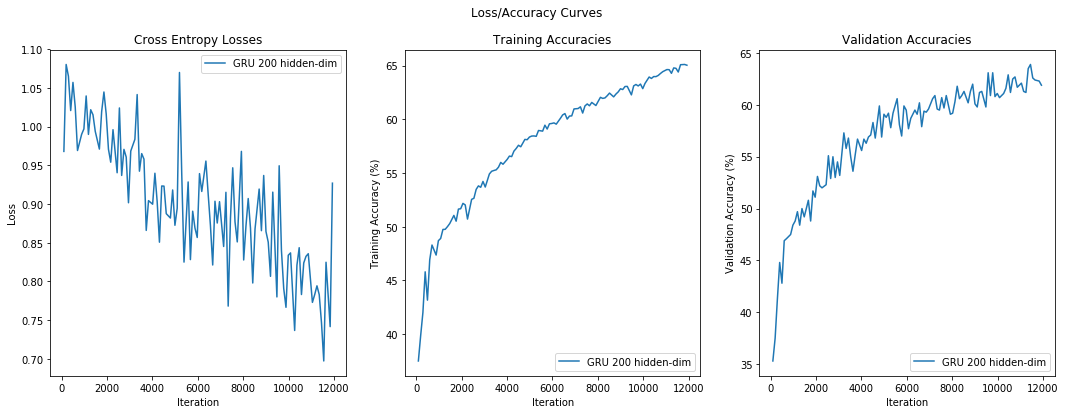

In [105]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(gru_losses.items())[:107]), label="GRU 200 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(gru_train_accs.items())[:107]), label="GRU 200 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(gru_val_accs.items())[:107]), label="GRU 200 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves')
plt.show()

In [85]:
gru_model_2, gru_train_accs_2, gru_val_accs_2, gru_losses_2 = train_gru_model(400)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch: [1/15], Step: [91/391], Training Acc: 40.38, Validation Acc: 39.7
Epoch: [1/15], Step: [181/391], Training Acc: 40.139, Validation Acc: 38.4
Epoch: [1/15], Step: [271/391], Training Acc: 44.923, Validation Acc: 44.7
Epoch: [1/15], Step: [361/391], Training Acc: 46.898, Validation Acc: 46.2
Epoch: [2/15], Step: [91/391], Training Acc: 48.188, Validation Acc: 48.9
Epoch: [2/15], Step: [181/391], Training Acc: 48.654, Validation Acc: 47.9
Epoch: [2/15], Step: [271/391], Training Acc: 49.512, Validation Acc: 48.3
Epoch: [2/15], Step: [361/391], Training Acc: 49.565, Validation Acc: 49.9
Epoch: [3/15], Step: [91/391], Training Acc: 50.477, Validation Acc: 50.6
Epoch: [3/15], Step: [181/391], Training Acc: 50.906, Validation Acc: 50.9
Epoch: [3/15], Step: [271/391], Training Acc: 50.301, Validation Acc: 50.0
Epoch: [3/15], Step: [361/391], Training Acc: 51.232, Validation Acc: 50.7
Epoch: [4/15], Step: [91/391], Training Acc: 51.842, Validation Acc: 50.7
Epoch: [4/15], Step: [181/391]

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
print(gru_val_accs_2)
print(losses)
axs[0].plot(*zip(*sorted(gru_losses_2.items())), label="GRU 400 hidden-dim")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(gru_train_accs_2.items())), label="GRU 400 hidden-dim")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(gru_val_accs_2.items())), label="GRU 400 hidden-dim")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves')
plt.show()

RuntimeError: This event loop is already running

SyntaxError: can't use starred expression here (cell_name, line 7)

In [19]:
cnn_model_2, cnn_train_accs_2, cnn_val_accs_2, cnn_losses_2 = train_cnn_model(100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


TypeError: forward() missing 1 required positional argument: 'x'

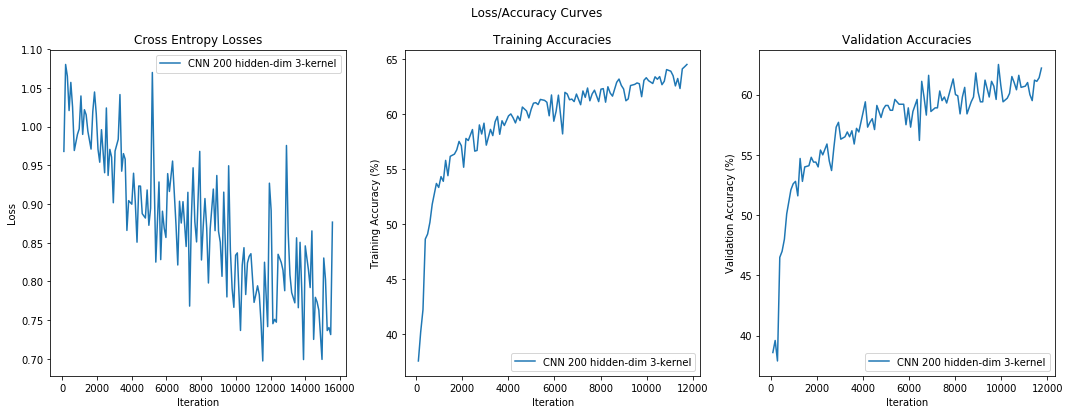

In [91]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(*zip(*sorted(gru_losses.items())), label="CNN 200 hidden-dim 3-kernel")
axs[0].set_title('Cross Entropy Losses')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")

axs[1].plot(*zip(*sorted(cnn_train_accs.items())), label="CNN 200 hidden-dim 3-kernel")
axs[1].set_title('Training Accuracies')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training Accuracy (%)')
axs[1].legend(loc="lower right")

axs[2].plot(*zip(*sorted(cnn_val_accs.items())), label="CNN 200 hidden-dim 3-kernel")
axs[2].set_title('Validation Accuracies')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Validation Accuracy (%)')
axs[2].legend(loc="lower right")

fig.suptitle('Loss/Accuracy Curves')
plt.show()